In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from collections import OrderedDict
import tables
import sys
sys.path.append('/Users/eframe/repos/dmi/src')
import calibrate as calib
import eventAnalysis as ea

In [2]:
linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

In [3]:
# Transmission Probability Function
def prob_trans( mu_mass, rho, thickness):
    prob = np.exp( -mu_mass * rho * thickness )
    return prob

In [4]:
def lump_edata(edata, twindow=30):
    """ Finding lower and upper indices of events that lie within the specified time window
    """
    t = np.diff( edata['timestamp'] )
    tmask = ( t > 25 )
    T = np.ma.masked_array( t, tmask ).filled( 0 )
    i2 = np.where( T == 0 )[0] + 1
    i1 = np.insert( i2[ :-1 ], 0, 0 )  

    return i1, i2

In [5]:
def is_single(event):
    """ Determines whether an event is a singles event in the first detector. Allows for charge sharing.
    """
    mask = event['trigger'] == 1
    fired = event[mask]

    d1 = ea.inge1(fired)
    d1_AC = ea.onAC(d1)
    d1_DC = ea.onDC(d1)

    lensAC = len(d1_AC)
    lensDC = len(d1_DC)

    e1_AC = np.sum( d1_AC['ADC_value'] )
    e1_DC = np.sum( d1_DC['ADC_value'] )

    if ( lensAC == 1 ) and ( lensDC  == 1 ):
        match = ea.checkForEnergyMatch( e1_AC, e1_DC, sigma = 2 )
        if np.sum(match) == 1:
            return True
        else: return False
    else:
        return False

In [6]:
def subtract_baseline(rdata, sample_window=15):
    """ Usage: subtract_baseline(rdata, sample_window=30) return rdata with the
    mean of the first sample_window samples having been subtracted from the
    entire signal
    """
    return rdata - rdata[:, 0:sample_window].mean(axis=1)[:, np.newaxis]

In [7]:
def search_t50(signal):
    """ Returns the t50 value of a raw signal
    """
    tMin = np.argmax(signal)
    sigMax = np.mean( signal[tMin:] )

    # Loop over signal to find t50 point
    t = 0
    t50_region_end = len(signal);
    while t < t50_region_end:
        if signal[t] > ( sigMax / 2 ):
            break
        t = t + 1

    #  Calculate t50 with linear interp
    t2 = t
    t1 = t2 - 1
    s2 = signal[t2]
    s1 = signal[t1]
    t50 = ( ( t2 - t1 ) / ( s2 - s1) ) * ( sigMax / 2 - s1 ) + t1

    return t50

In [19]:
mu_mass = 5.020 # 1.718 cm2/g at 160 keV, 5.020 at 60 keV
rho = 11.34 # g/cm3
thickness = -np.log(0.0001) / ( mu_mass * rho )
print(thickness * 10)

1.617926946881993


In [11]:
# Transmission Probability w.r.t Thickness
energies = np.array( [ 122, 186, 218, 440, 662, 1001 ])
mu_mass_Ge = np.array( [ 3.627E-01, 1.817E-01, 1.507E-01, 8.819E-02, 7.081E-02, 5.724E-02 ] ) # cm2/g
mu_mass_W = np.array( [ 2.672E+00, 9.321E-01, 6.422E-01, 1.657E-01, 9.776E-02, 6.612E-02 ] ) # cm2/g
rho_Ge = 5.5 # g/cm3
rho_W = 19.35 # g/cm3
thickness = np.arange(0, 10, 0.001)
prob_trans_Ge, prob_trans_W = [], []
for i in np.arange( len( mu_mass_Ge ) ):
    prob_trans_Ge.append( prob_trans( mu_mass_Ge[i], rho_Ge, thickness ) )
    prob_trans_W.append( prob_trans( mu_mass_W[i], rho_W, thickness ) )

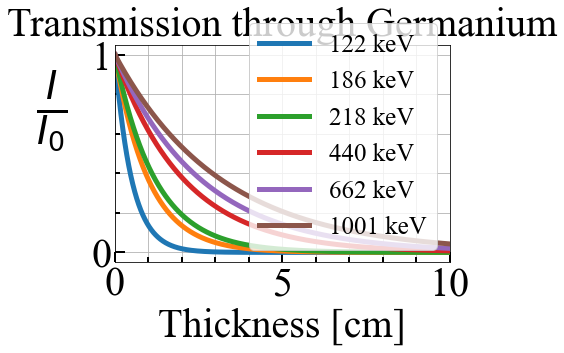

In [12]:
%matplotlib inline
# Transmission through Ge
font = FontProperties()
font.set_name('Times New Roman')
fig, ax = plt.subplots()
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in', labelsize=40)
ax.tick_params(which='minor', length=5, width=2, direction='in')
ax.set_xlabel('Thickness [cm]', fontsize=40, fontproperties=font)
ax.set_ylabel(r'$\frac{I}{I_0}$', rotation=0, fontsize=55, fontproperties=font, labelpad=40)
ax.set_title('Transmission through Germanium', fontsize=40, fontproperties=font)
ax.plot( thickness, prob_trans_Ge[0], linewidth=5, label='122 keV')
ax.plot( thickness, prob_trans_Ge[1], linewidth=5, label='186 keV')
ax.plot( thickness, prob_trans_Ge[2], linewidth=5, label='218 keV')
ax.plot( thickness, prob_trans_Ge[3], linewidth=5, label='440 keV')
ax.plot( thickness, prob_trans_Ge[4], linewidth=5, label='662 keV')
ax.plot( thickness, prob_trans_Ge[5], linewidth=5, label='1001 keV')

ax.legend(prop={"family":"Times New Roman", 'size': 25} )
ax.tick_params(labelsize=40)
ax.set_xlim(0,10)
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)  
ax.grid(which='both')
plt.show()

In [14]:
%matplotlib qt
# Transmission through W
font = FontProperties()
font.set_name('Times New Roman')
fig, ax = plt.subplots()
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in', labelsize=40)
ax.tick_params(which='minor', length=5, width=2, direction='in')
ax.set_xlabel('Thickness [cm]', fontsize=40, fontproperties=font)
ax.set_ylabel(r'$\frac{I}{I_0}$', rotation=0, fontsize=55, fontproperties=font, labelpad=40)
ax.set_title('Transmission through Tungsten', fontsize=40, fontproperties=font)
ax.plot( thickness, prob_trans_W[0], linewidth=5, label='122 keV')
ax.plot( thickness, prob_trans_W[1], linewidth=5, label='186 keV')
ax.plot( thickness, prob_trans_W[2], linewidth=5, label='218 keV')
ax.plot( thickness, prob_trans_W[3], linewidth=5, label='440 keV')
ax.plot( thickness, prob_trans_W[4], linewidth=5, label='662 keV')
ax.plot( thickness, prob_trans_W[5], linewidth=5, label='1001 keV')
ax.set_xlim(0,2)
ax.legend(prop={"family":"Times New Roman", 'size': 25} )
ax.tick_params(labelsize=40)
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)  
ax.grid(which='both')
plt.show()

In [13]:
# Attenuation Coefficient Plot in Ge
%matplotlib qt
mu_mass = np.loadtxt('/Users/eframe/dissertation/data/ge_mass_atten.txt')
energy = mu_mass[:,0] * 1000
mu_cs = mu_mass[:,1]
mu_pe = mu_mass[:,2]
mu_pp = mu_mass[:,3]

font = FontProperties()
font.set_name('Times New Roman')
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in', labelsize=40, pad=15)
ax.tick_params(which='minor', length=5, width=2, direction='in')
ax.set_xlabel('Energy [keV]', fontsize=40, fontproperties=font)
ax.set_ylabel(r'$\mu \ \frac{cm^2}{g}$', fontsize=40, fontproperties=font)
ax.plot( energy, mu_pe, linestyle = linestyles['solid'], linewidth=5, label='Photoelectric Absorption')
ax.plot( energy, mu_cs, linestyle = linestyles['densely dashed'], linewidth=5, label='Compton Scattering')
ax.plot( energy, mu_pp, linestyle = linestyles['densely dotted'], linewidth=5, label='Pair Production')
ax.set_xlim(min(energy), max(energy))
ax.legend(prop={"family":"Times New Roman", 'size': 25} )
ax.tick_params(labelsize=40)
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)  
ax.grid(which='both')
plt.show()

In [ ]:
# Getting Raw Signal of Matching AC and DC
file = '/Users/eframe/dissertation/data/cs137_raw.h5'
f = tables.open_file( file, 'r' )
edata = f.root.EventData.read().view( np.recarray )
edata.rid = np.arange( len( edata ) )
edata = np.sort( edata, order='timestamp' )
i1, i2 = lump_edata( edata, twindow=25 )

# Subtracting Baseline from Raw Data
rdata = f.root.RawData.read().view( np.recarray )
rdata2 = subtract_baseline( rdata )

In [ ]:
single = []
for i in np.arange( 500, 2000 ):
    event = edata[i1[i]:i2[i]]
    if is_single( event ) :
        single.append(event)

In [ ]:
# Getting Raw Signal of Matching AC and DC
i = 1
event = single[i]
trigsort = np.sort( np.sort( event, order='trigger' )[-2:], order = 'detector' )
esort = np.sort( event, order='ADC_value' )
detsort = np.sort( esort[-2:], order='detector' )
rid_h = trigsort['rid'][0]
rid_e = trigsort['rid'][1]
raw_h = rdata2[rid_h]
raw_e = rdata2[rid_e]

t50_h = search_t50(raw_h) 
t50_e = search_t50(raw_e)

dt50 = t50_e - t50_h
dt = int( detsort.timestamp[1] ) - int( detsort.timestamp[0] )
dt50_new = (t50_e + detsort.timestamp[1]) - (t50_h + detsort.timestamp[0]) 
zpos = dt50_new * 0.3215503 + 7.9596899

if detsort.timestamp[0] < detsort.timestamp[1]:
    time_h = ( np.arange( len(raw_h ) ) ) * 10
    time_e = ( np.arange( len(raw_e ) ) + np.abs( dt ) ) * 10 
    t50_h = t50_h * 10
    t50_e = ( t50_e + np.abs( dt ) ) * 10 
else:
    time_h = ( np.arange( len( raw_h ) ) + np.abs( dt ) ) * 10
    time_e = ( np.arange( len(raw_e ) ) ) * 10
    t50_e = t50_e * 10
    t50_h = ( t50_h + np.abs( dt ) ) * 10

print(t50_h, t50_e, zpos, dt50_new*10)

In [ ]:
# # Finding Trigger Time to Initial Start of Charge Collection
# mask = raw_h>25
# time_h[mask]

In [ ]:
# Getting Raw Signal of Matching AC and DC
%matplotlib inline
triggertime = 370 #ns
font = FontProperties()
font.set_name('Times New Roman')
fig, ax = plt.subplots()
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in', labelsize=40)
ax.tick_params(which='minor', length=5, width=2, direction='in')
ax.set_xlabel('Time [ns]', fontsize=40, fontproperties=font)
ax.set_ylabel('Induced Charge Signal', fontsize=40, fontproperties=font, labelpad=20)
ax.plot( time_h-triggertime, raw_h, linewidth=4, label=r'Holes: $T_{50} = %.1f$ ns'  %(t50_h-triggertime))
ax.plot( time_e-triggertime, raw_e, linewidth=4, label=r'Electrons:  $T_{50} = %.1f$ ns' %(t50_e-triggertime))
ax.set_xlim(-180 , 1000 )
ax.tick_params(labelsize=40)
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)  
ax.grid(which='both')
legend = ax.legend(prop={"family":"Times New Roman", 'size': 40}, frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show()

In [ ]:
# Maximum Energy Limit for Compton Scattering 
%matplotlib inline
energy = np.arange(0, 1000)
Emax  = []
for i in np.arange( len(energy ) ):
    Egamma = energy[i]
    Emax.append( Egamma - Egamma / ( 1 + ( 2 * Egamma ) / ( 511 ) ) )
    
font = FontProperties()
font.set_name('Times New Roman')
fig, ax = plt.subplots()
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in', labelsize=40)
ax.tick_params(which='minor', length=5, width=2, direction='in')
ax.set_xlabel('Incident Photon Energy [keV]', fontsize=40, fontproperties=font)
ax.set_ylabel('Maximum Energy Deposition [keV]', fontsize=40, fontproperties=font, labelpad=20)
ax.plot( energy, Emax, linewidth=4 )
ax.tick_params(labelsize=40)
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)  
ax.grid(which='both')
plt.show()

In [8]:
# Calculating the Optimal Open Fracton
muT = 0.01
PSI = np.arange( 0, 1, 0.01 )
mask = PSI != 0.5
PSI = PSI[mask]
EPS = np.array( [ 0 ] )

RHO_all = []
for i in np.arange( len( EPS ) ):
    RHO = []
    for j in np.arange( len( PSI ) ):
        eps = EPS[i]
        psi = PSI[j]
        num1 = muT + eps + psi * ( 1 - 2 * muT )
        square1 = ( muT + eps + psi * (1 - 2 * muT ) ) ** 2
        square2 = ( 1 - muT ) * (2 * psi - 1 ) * ( psi * (1 - muT ) + muT + eps )
        num2 = np.sqrt(square1 - square2)
        num = num1 - num2      
        den = ( 1 - muT ) * (2 * psi - 1 )
        rho = num / den
        if (square1-square2) < 0:
            print(eps, psi, rho)
        RHO.append( rho )
    RHO_all.append( RHO )     

In [17]:
# Graphing the Optimal Open Fraction vs. Source Distribution 
%matplotlib qt
font = FontProperties()
font.set_name('Times New Roman')
fig, ax = plt.subplots()
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in', labelsize=40)
ax.tick_params(which='minor', length=5, width=2, direction='in')
ax.set_xlabel(r'$\psi_{j}$', fontsize=40, fontproperties=font)
ax.set_ylabel(r'$\rho_{j, opt}$', fontsize=40, fontproperties=font, labelpad=20)
ax.plot( PSI, RHO_all[0], linestyle = linestyles['solid'], linewidth=4 )
ax.tick_params(labelsize=40)
ax.set_xlim(0,1)
ax.set_ylim(0.01,1)
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)  
ax.grid(which='both')
plt.show()

In [19]:
# Calculating the Performance Advangtage of a Coded Aperture
n = 64 * 64
PSI = np.array( [ 0.01, 0.05, 0.1, 0.5, 1 ]) 
RHO = np.arange( 0.001, 1.0, 0.01 )
rhoPIN = 1 / n
eps = 0

ratio_all = []
ratio_max = []
for i in np.arange( len( PSI ) ):
    ratio = []
    for j in np.arange( len( RHO ) ):
        psi = PSI[i]
        rhoCA = RHO[j]
        num = np.sqrt( rhoCA * ( 1 - rhoCA) ) * np.sqrt( rhoPIN + ( 1 - 2 * rhoPIN ) * psi + eps ) 
        den = np.sqrt( rhoPIN * ( 1 - rhoPIN) ) * np.sqrt( rhoCA + ( 1 - 2 * rhoCA ) * psi + eps )
        r = num / den
        ratio.append( r )
    ratio_all.append( ratio )  
    ratio_max.append( [ max(ratio), RHO[np.argmax(ratio)] ] )

In [22]:
# Graphing the Optimal Open Fraction vs. Source Distribution 
%matplotlib qt
font = FontProperties()
font.set_name('Times New Roman')
fig, ax = plt.subplots()
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in', labelsize=40)
ax.tick_params(which='minor', length=5, width=2, direction='in')
ax.set_xlabel(r'$\rho_{ca}$', fontsize=40, fontproperties=font)
ax.set_ylabel(r'$SNR_{ca} \ / \ SNR_{pin}$', fontsize=40, fontproperties=font, labelpad=10)

ax.plot( RHO, ratio_all[0], linestyle = linestyles['solid'], linewidth=4, label=r'$\psi_{j} = 0.01$' )
ax.plot( RHO, ratio_all[1], linestyle = linestyles['solid'], linewidth=4, label=r'$\psi_{j} = 0.05$' )
ax.plot( RHO, ratio_all[2], linestyle = linestyles['solid'], linewidth=4, label=r'$\psi_{j} = 0.1$' )
ax.plot( RHO, ratio_all[3], linestyle = linestyles['solid'], linewidth=4, label=r'$\psi_{j} = 0.5$' )
ax.plot( RHO, ratio_all[4], linestyle = linestyles['solid'], linewidth=4, label=r'$\psi_{j} = 1$' )

ax.axvline( ratio_max[0][1], ymin = 0, ymax=ratio_max[0][0]/65, color='tab:blue', 
           linestyle = linestyles['solid'], linewidth=0, marker='o', markersize=15, markeredgecolor='k',
           markevery=[-1], label=r'$SNR_{ca}=6\times SNR_{pin}$')
ax.axvline( ratio_max[1][1], ymin = 0, ymax=ratio_max[1][0]/65, color='tab:orange', 
           linestyle = linestyles['solid'], linewidth=0, marker='o', markersize=15, markeredgecolor='k', 
           markevery=[-1], label=r'$SNR_{ca}=12\times SNR_{pin}$')
ax.axvline( ratio_max[2][1], ymin = 0, ymax=ratio_max[2][0]/65, color='tab:green', 
           linestyle = linestyles['solid'], linewidth=0, marker='o', markersize=15, markeredgecolor='k', 
           markevery=[-1], label=r'$SNR_{ca}=16\times SNR_{pin}$')
ax.axvline( ratio_max[3][1], ymin = 0, ymax=ratio_max[3][0]/65, color='tab:red', 
           linestyle = linestyles['solid'], linewidth=0, marker='o', markersize=15, markeredgecolor='k',
           markevery=[-1], label=r'$SNR_{ca}=32\times SNR_{pin}$')
ax.axvline( ratio_max[4][1], ymin = 0, ymax=ratio_max[4][0]/65, color='tab:purple', 
           linestyle = linestyles['solid'], linewidth=0, marker='o', markersize=15, markeredgecolor='k',
           markevery=[-1], label=r'$SNR_{ca}=64\times SNR_{pin}$')

ax.tick_params(labelsize=40)
ax.set_xlim( 0, 1 )
ax.set_ylim( 0.01, 65 )
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)  
ax.grid(which='both')
legend = ax.legend(prop={"family":"Times New Roman", 'size': 20}, loc="upper left", ncol=2, frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show()

In [9]:
%matplotlib qt
file = '/Users/eframe/Downloads/co57events.h5'
sourceEnergy, sigma = 122, 2

# Loading Source Detector Data
data = tables.open_file(file, 'r')
l11 = data.root.Interactions.Single.read()
mask = ( l11['det'] == 1 )
maskZ = ( l11[mask]['z'] < 5 )
singles = l11[mask][maskZ]
data.close()

xedges, yedges = np.arange(0, 76, 2),  np.arange(0, 76, 2)

maskE = ( np.array( singles['energy'] ) > sourceEnergy - sigma ) &\
        ( np.array( singles['energy'] ) < sourceEnergy + sigma )
singles = singles[maskE]

grid, X, Y = np.histogram2d(singles['x'], singles['y'], bins=(xedges, yedges) )
counts = np.flip(grid, 1)

# Plotting Detector Response
font = FontProperties()
font.set_name('Times New Roman')
binSize = 2
fig, ax = plt.subplots()
im = ax.pcolormesh(X, Y, counts.T)
ax.xaxis.set_ticks(np.arange(0, 74, 10))
ax.yaxis.set_ticks(np.arange(0, 74, 10))
ax.tick_params(labelsize=150)
ax.set_xlabel('x [mm]', fontsize=40, fontproperties=font, labelpad=15)
ax.set_ylabel('y [mm]', fontsize=40, fontproperties=font, labelpad=20)
ax.set_aspect('equal', adjustable='box')
cbar = plt.colorbar(im)
cbar.set_label(label='Selected Events', rotation=270, fontsize=40, fontproperties=font, labelpad=20)
cbar.ax.tick_params(labelsize=40)
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
plt.show()

In [52]:
# Displaying Sensitivity Map
binSize = 2
sourceX, sourceY, sourceZ = np.mgrid[ -49:51:binSize, -49:51:binSize, -49:51:binSize ]
sourcePixels = np.array( [ sourceX.flatten(), sourceY.flatten(), sourceZ.flatten() ] ).T
poses = np.array( [ 0, 45, 90, 135, 180, 225, 270, 315 ] ) * np.pi / 180
center = np.array( [ 0, 0, 50] )
sourcePixelsNew = []
for i in np.arange( len( poses ) ):
    ang = poses[ i ]
    R = np.array( [  [ np.cos( ang ), 0, np.sin( ang ) ], 
                   [ 0, 1, 0 ], 
                   [ -np.sin( ang ), 0, np.cos( ang ) ] ] )
    B = np.array( [ [ 1, 0, 0 ], [ 0, 1, 0 ], [ 0, 0, 1 ] ] )
    K = np.array( np.dot( R, B ) )
    sourcePixelsNew.append(  np.dot( sourcePixels, R ) + center ) 

sensMap = []
det = 37
for i in np.arange( len(poses) ):
    x = np.round( sourcePixelsNew[i][:,0] ).astype(int)
    y = np.round( sourcePixelsNew[i][:,1] ).astype(int)
    z = np.round( sourcePixelsNew[i][:,2] ).astype(int)
    c1 = x + det
    c2 = x - det
    d1 = y + det
    d2 = y - det
    a1 = c1 / np.sqrt( c1 ** 2 + z ** 2 )
    b1 = d1 / np.sqrt( d1 ** 2 + z ** 2 )
    a2 = c2 / np.sqrt( c2 ** 2 + z ** 2 )
    b2 = d2 / np.sqrt( d2 ** 2 + z ** 2 )
    firstsum = np.arcsin( a1 * b1 ) * ( ( -1 ) ** 2 ) + np.arcsin( a1 * b2 ) * ( ( -1 ) ** 3 )
    secondsum = np.arcsin( a2 * b1 ) * ( ( -1 ) ** 3 ) + np.arcsin( a2 * b2 ) * ( ( -1 ) ** 4 )
    sens =  ( firstsum + secondsum ) / ( 4 * np.pi ) 
    sensMap.append( sens )

In [54]:
%matplotlib inline
sensval = np.array(sensMap).sum(0).reshape(sourceX.shape)
a, b = min(sensval.flatten()), max(sensval.flatten())
sX, sZ = np.mgrid[ -49:51:binSize, :99:binSize ]
font = FontProperties()
font.set_name('Times New Roman')
fig, ax = plt.subplots()
grid = sensval[ :, 25, :] 
im = ax.pcolormesh( sX, sZ, grid, cmap='jet', vmin=a, vmax=b, shading = 'gouraud' ) 
ax.tick_params(labelsize=150)
ax.set_xlabel('X-Distance from Center of FOV [mm]', fontsize=40, fontproperties=font, labelpad=0)
ax.set_ylabel('Z-Distance from Detector Surface [mm]', fontsize=40, fontproperties=font, labelpad=20)
ax.set_aspect('equal', adjustable='box')
cbar = plt.colorbar(im)
cbar.set_label(label=r'Sensitivity', rotation=270, fontsize=40, fontproperties=font, labelpad=40)
cbar.ax.tick_params(labelsize=40)
ax.xaxis.set_ticks(np.arange(-40, 50, 10))
ax.yaxis.set_ticks(np.arange(10, 100, 10))
ax.set_xticklabels(ax.get_xticks(), rotation = 45)
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
plt.show()

In [10]:
f122 = np.array([31, 27.5, 13.8, 13.1])
f218 = np.array([19.8, 16.8, 9.48, 8.81])
f440 = np.array([14.2, 11.7, 7.52, 6.69])
f662 = np.array([12.2, 9.86,7.32, 6.17])
f1001 = np.array([11.6, 9.42, 6.52, 5.84])
f1408 = np.array([10.9, 8.92, 6.01, 4.78])

s122 = np.array([0.131, 0.0996, 0.00661, 0.00607])
s218 = np.array([0.128, 0.0891, 0.0228, 0.0188])
s440 = np.array([0.0473, 0.0291, 0.0124, 0.00865])
s662 = np.array([0.0262, 0.0147, 0.00771, 0.00493])
s1001 = np.array([0.0153, 0.00801, 0.00471, 0.00265])
s1408 = np.array([0.00991, 0.00486, 0.00312, 0.00168])

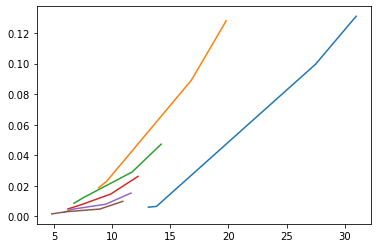

In [11]:
plt.plot(f122, s122, label="E=122 keV")
plt.plot(f218, s218, label="E=218 keV")
plt.plot(f440, s440, label="E=440 keV")
plt.plot(f662, s662, label="E=662 keV")
plt.plot(f1001, s1001, label="E=1001 keV")
plt.plot(f1408, s1408, label="E=1408 keV")